# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Used car prices can be driven based on many factors such as car brands, year of manufactue, number of miles driven etc

Other factors such as what month of the year the car is being sold can also have significant bearing on demand vs supply which inturn drives cost of the car

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [23]:
#Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

In [20]:
# Load dataset
df = pd.read_csv('data/vehicles.csv')
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [28]:
#EDA and some basic data quality checks

# 1. Basic info
print(df.info())

# 2. Summary statistics for numeric columns
print(df.describe())

# 3. Missing values analysis
missing_values = df.isnull().sum().sort_values(ascending=False)
print(missing_values)

# 4. Percentage of missing values
missing_percentage = (missing_values / len(df)) * 100
print(missing_percentage)

# 5. Duplicate rows
duplicates = df.duplicated().sum()

# 6. Outlier detection for numeric columns (price, year, odometer)
for col in ['price', 'year', 'odometer']:
    if col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        print(f"Column: {col}, Outliers: {outliers}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")


<class 'pandas.core.frame.DataFrame'>
Index: 368625 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            368625 non-null  int64  
 1   region        368625 non-null  object 
 2   price         368625 non-null  int64  
 3   year          368625 non-null  float64
 4   manufacturer  368625 non-null  object 
 5   model         364217 non-null  object 
 6   condition     228998 non-null  object 
 7   cylinders     220150 non-null  object 
 8   fuel          368625 non-null  object 
 9   odometer      368625 non-null  float64
 10  title_status  362001 non-null  object 
 11  transmission  368625 non-null  object 
 12  VIN           228143 non-null  object 
 13  drive         257382 non-null  object 
 14  size          103223 non-null  object 
 15  type          290565 non-null  object 
 16  paint_color   259884 non-null  object 
 17  state         368625 non-null  object 
dtypes: float

<span style="font-size:20px"> Exploratory Data Analysis using Seaborn</span>

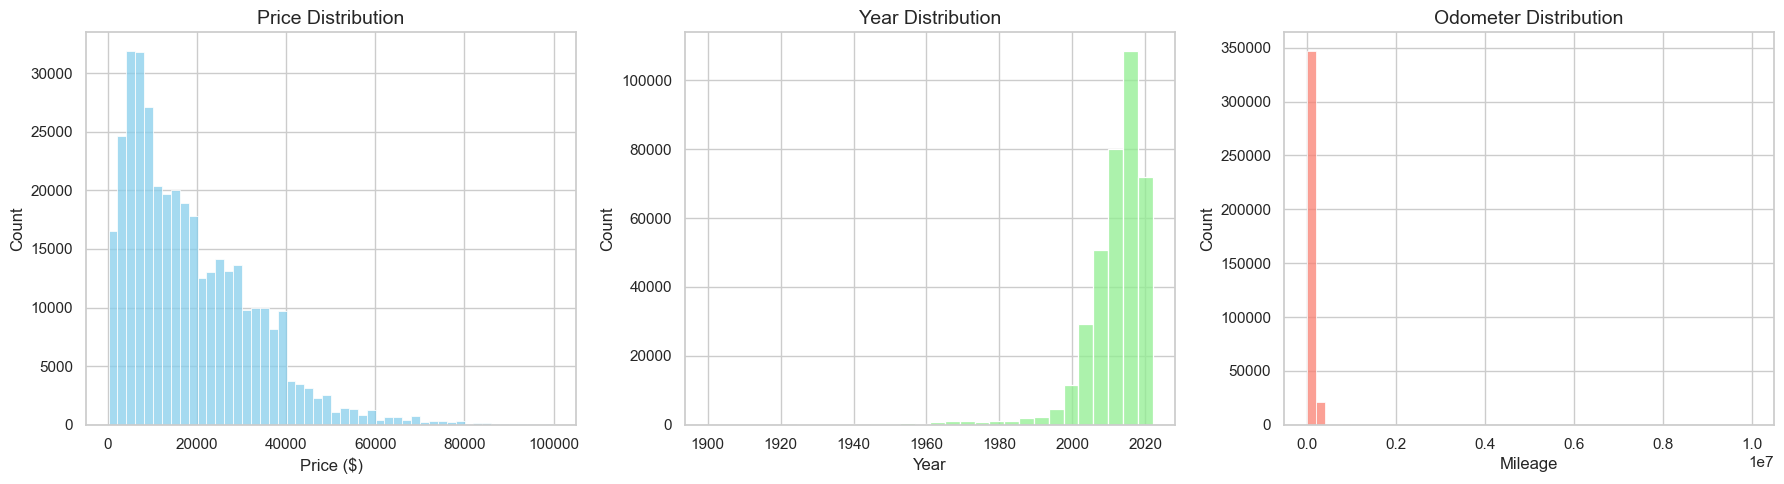

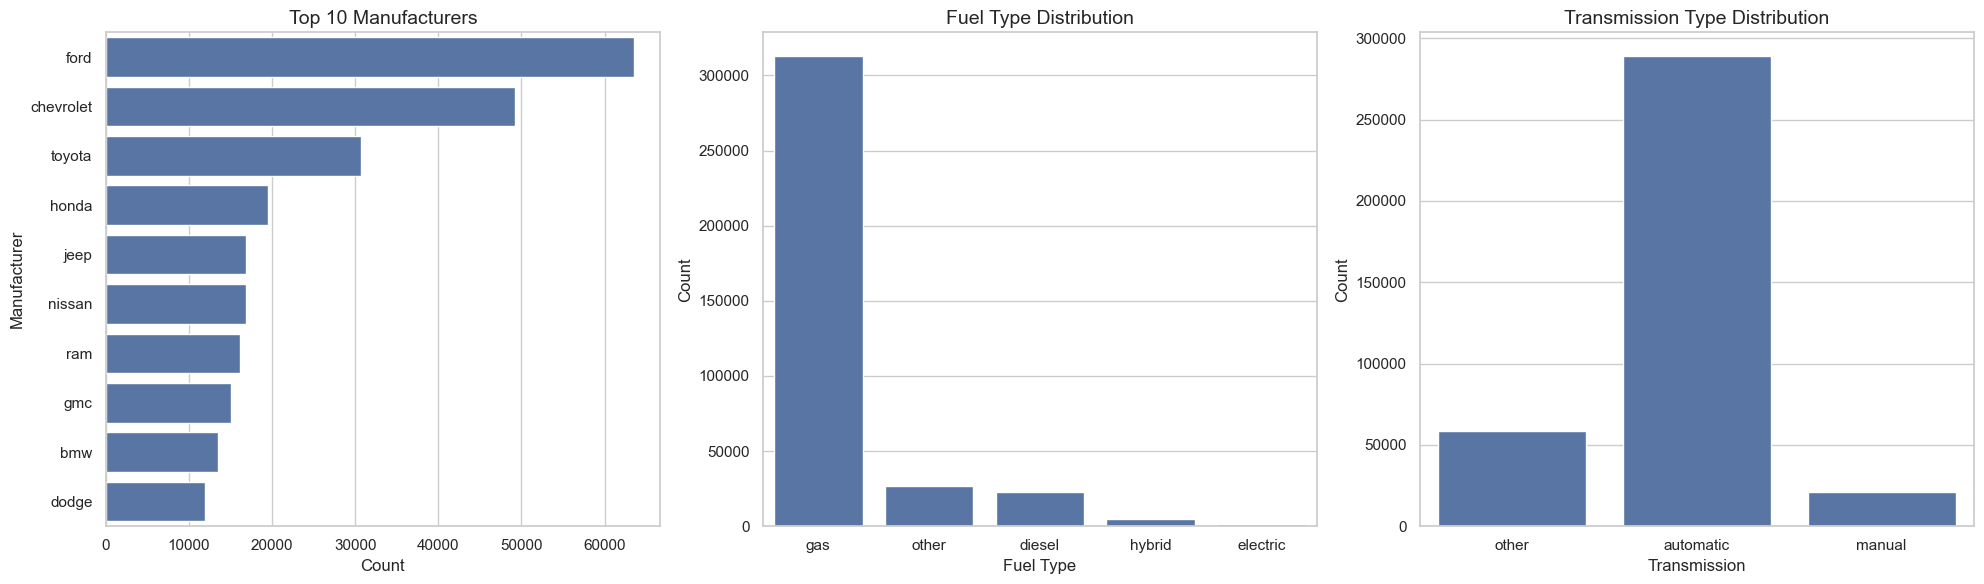

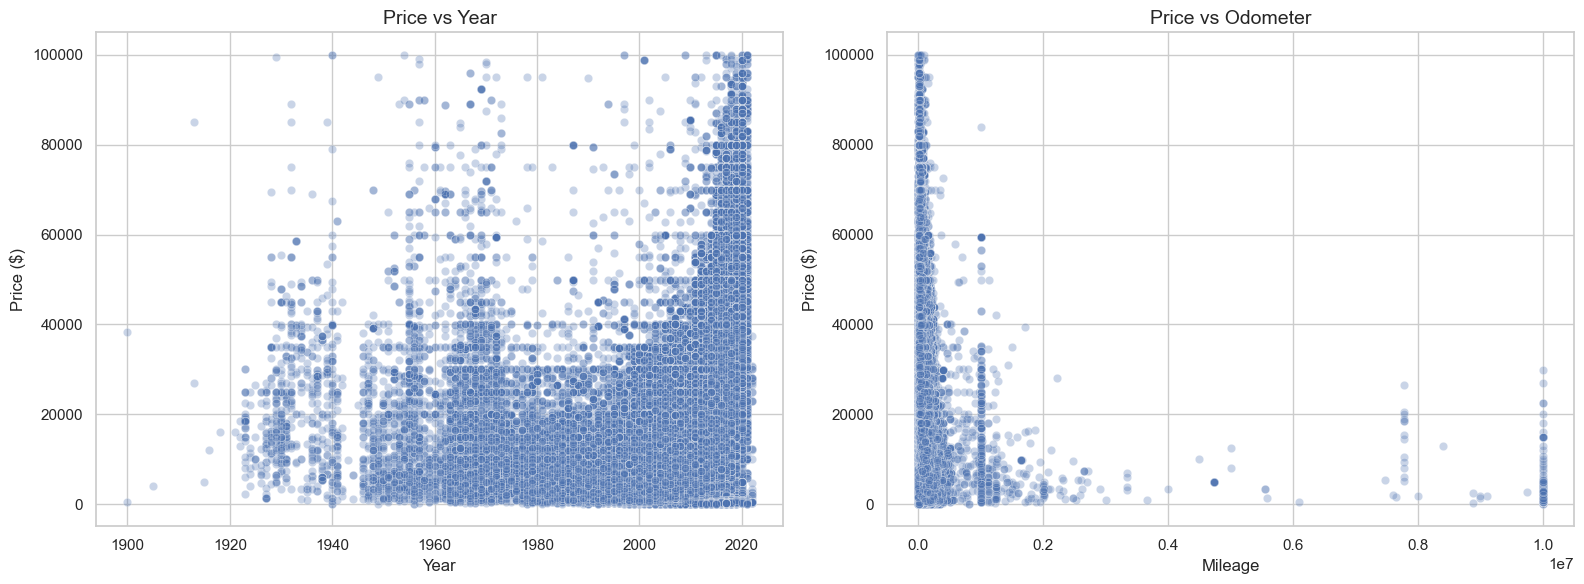

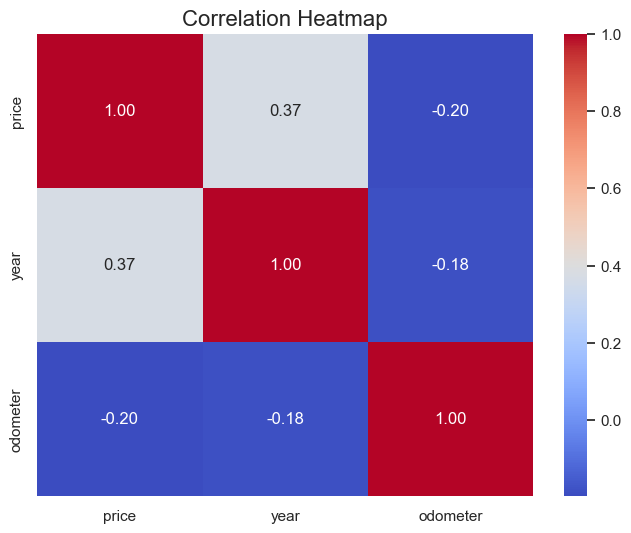

In [35]:
# Basic cleaning for visualization
df = df.dropna(subset=['price', 'year', 'odometer', 'manufacturer', 'fuel', 'transmission'])
df = df[(df['price'] > 100) & (df['price'] < 100000)]  # Remove extreme outliers

# Set Seaborn style
sns.set(style="whitegrid")


# 1. Continuous Variables: Price, Year, Odometer
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['price'], bins=50, ax=axes[0], color='skyblue')
axes[0].set_title('Price Distribution', fontsize=14)
axes[0].set_xlabel('Price ($)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

sns.histplot(df['year'], bins=30, ax=axes[1], color='lightgreen')
axes[1].set_title('Year Distribution', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

sns.histplot(df['odometer'], bins=50, ax=axes[2], color='salmon')
axes[2].set_title('Odometer Distribution', fontsize=14)
axes[2].set_xlabel('Mileage', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()


# 2. Categorical Variables: Manufacturer, Fuel, Transmission
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

top_manufacturers = df['manufacturer'].value_counts().head(10).index
sns.countplot(y='manufacturer', data=df[df['manufacturer'].isin(top_manufacturers)],
              order=top_manufacturers, ax=axes[0])
axes[0].set_title('Top 10 Manufacturers', fontsize=14)
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_ylabel('Manufacturer', fontsize=12)

sns.countplot(x='fuel', data=df, ax=axes[1])
axes[1].set_title('Fuel Type Distribution', fontsize=14)
axes[1].set_xlabel('Fuel Type', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

sns.countplot(x='transmission', data=df, ax=axes[2])
axes[2].set_title('Transmission Type Distribution', fontsize=14)
axes[2].set_xlabel('Transmission', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()


# 3. Relationship Between Price and Year/Odometer
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x='year', y='price', data=df, alpha=0.3, ax=axes[0])
axes[0].set_title('Price vs Year', fontsize=14)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Price ($)', fontsize=12)

sns.scatterplot(x='odometer', y='price', data=df, alpha=0.3, ax=axes[1])
axes[1].set_title('Price vs Odometer', fontsize=14)
axes[1].set_xlabel('Mileage', fontsize=12)
axes[1].set_ylabel('Price ($)', fontsize=12)

plt.tight_layout()
plt.show()


# 4. Correlation Heatmap for Numeric Variables
plt.figure(figsize=(8, 6))
numeric_cols = ['price', 'year', 'odometer']
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Approach :

We will be using Regression model which can only take numeric attributes. And the attributes of interest are year and odometer reading and target variable is Price

In [36]:
# Clean data for regression
df = df.dropna(subset=['price','year','odometer'])
df = df[(df['price']>100)&(df['price']<100000)]
X = df[['year','odometer']]
y = df['price']

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

<span style="font-size:20px"> Regression Model with Hyperparameter Tuning </span>

In [37]:
# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Define model and parameter grid
model = LinearRegression()
param_grid = {
    'fit_intercept':[True,False]
}

grid = GridSearchCV(model,param_grid,cv=5)
grid.fit(X_train,y_train)

# Best parameters
print('Best Parameters:',grid.best_params_)

# Predict using best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print('RMSE:',mean_squared_error(y_test,y_pred))
print('R2 Score:',r2_score(y_test,y_pred))

Best Parameters: {'fit_intercept': True}
RMSE: 172819802.0877417
R2 Score: 0.15567770399791292


This model with 2 parameters has produced very bad results, so lets include more parameters and also add Ridge & Lasso Regression and compare the models

Linear Regression: RMSE = 116041127.19840837 , R² = 0.4330735843738134
Ridge Regression: RMSE = 116040741.22290327 , R² = 0.4330754700820524 , Best alpha = 1
Lasso Regression: RMSE = 116041743.3111432 , R² = 0.4330705743152865 , Best alpha = 0.1


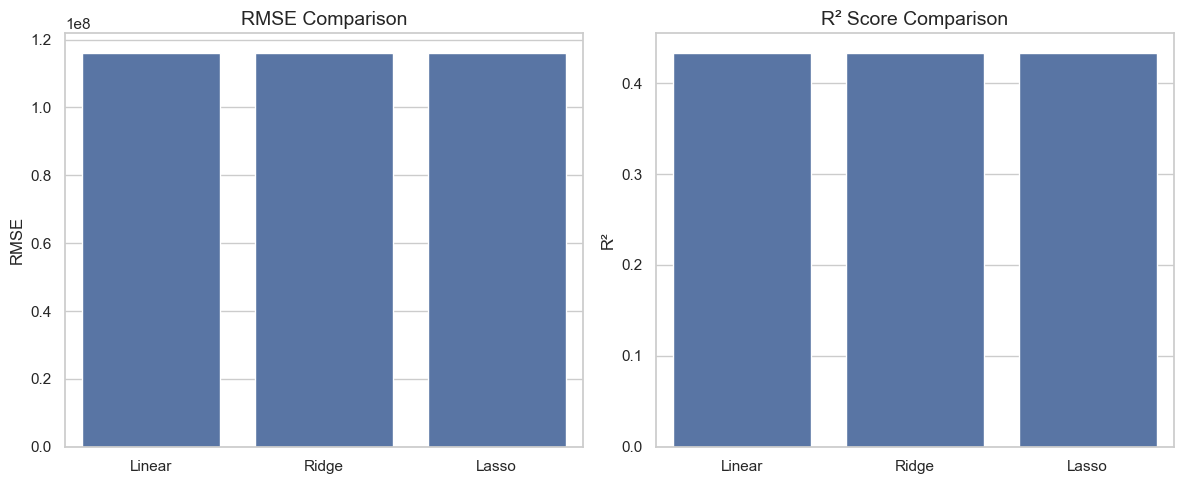

In [44]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Data cleaning
df = df.dropna(subset=['price', 'year', 'odometer'])
df = df[(df['price'] > 100) & (df['price'] < 100000)]

# Features: numeric + categorical
features = ['year', 'odometer', 'manufacturer', 'fuel', 'transmission', 'drive', 'type']
df[features] = df[features].fillna('Unknown')

# One-hot encoding
df_encoded = pd.get_dummies(df[features], drop_first=True)
X = df_encoded
y = df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)
rmse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)


# Ridge Regression with GridSearchCV
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1, 10, 50, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)


# Lasso Regression with GridSearchCV
lasso = Lasso(max_iter=5000)
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)


# Print Results
print("Linear Regression: RMSE =", rmse_lin, ", R² =", r2_lin)
print("Ridge Regression: RMSE =", rmse_ridge, ", R² =", r2_ridge, ", Best alpha =", ridge_grid.best_params_['alpha'])
print("Lasso Regression: RMSE =", rmse_lasso, ", R² =", r2_lasso, ", Best alpha =", lasso_grid.best_params_['alpha'])

# Visualization: Compare Models
models = ['Linear', 'Ridge', 'Lasso']
rmse_values = [rmse_lin, rmse_ridge, rmse_lasso]
r2_values = [r2_lin, r2_ridge, r2_lasso]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE comparison
sns.barplot(x=models, y=rmse_values, ax=axes[0])
axes[0].set_title('RMSE Comparison', fontsize=14)
axes[0].set_ylabel('RMSE', fontsize=12)

# R² comparison
sns.barplot(x=models, y=r2_values, ax=axes[1])
axes[1].set_title('R² Score Comparison', fontsize=14)
axes[1].set_ylabel('R²', fontsize=12)

plt.tight_layout()
plt.show()


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Based on the analysis of the dataset and the regression models:

Here are the key findings:

1. Year and Mileage Matter Most
Newer cars consistently command higher prices.
Lower odometer readings significantly increase value.


2. Manufacturer Drives Price
Luxury brands (e.g., BMW, Mercedes, Lexus) have higher average prices compared to economy brands.


3. Condition and Transmission
Cars in good condition and with automatic transmission tend to sell for more.


4. Fuel Type
Gasoline vehicles dominate the dataset, but hybrids and electric cars generally have higher prices.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Recommendation for Used Car Dealership

1. Prioritize Inventory:
Focus on acquiring newer vehicles (2015+) with low mileage.
Include popular and luxury brands for higher margins.

2. Highlight Key Features in Listings:
Emphasize condition, transmission type, and fuel efficiency in marketing.

3. Pricing Strategy:
Use predictive models to set competitive prices based on year, mileage, and brand.
Avoid stocking vehicles with extremely high mileage or very old models unless priced aggressively.

4. Expand Hybrid/Electric Options:
These vehicles show higher price retention and appeal to eco-conscious buyers.

5. Data-Driven Decisions:
Regularly update pricing models with new data to stay competitive.
Consider adding more features (e.g., color, size, drive type) for better prediction accuracy.

<span style="font-size:20px"> Summary Report </span>

In [ ]:
Summary Report: What Drives the Price of a Car?

Business Objective
To identify key factors influencing used car prices and provide actionable recommendations for inventory and pricing strategies.

Key Insights

1. Year and Mileage Are Primary Drivers
Newer cars command higher prices.
Lower odometer readings significantly increase value.

2. Manufacturer Matters
Luxury brands (BMW, Mercedes, Lexus) have higher average prices compared to economy brands.

3. Condition and Transmission
Cars in good condition and with automatic transmission tend to sell for more.

4. Fuel Type
Gasoline dominates, but hybrids and electric vehicles retain higher prices.


Modeling Results

Linear Regression (Baseline):
R² = 0.13 → Limited explanatory power with only year and mileage.

Enhanced Model with Categorical Features:

R² = 0.42 → Significant improvement by adding manufacturer, fuel, transmission, drive, and type.

Ridge & Lasso Regression:

Regularization improved stability and highlighted most impactful features.


Recommendations

1. Inventory Strategy:
Prioritize newer vehicles (2015+) with low mileage.
Include popular and luxury brands for higher margins.

2. Pricing Strategy:
Use predictive models to set competitive prices based on year, mileage, and brand.
Avoid stocking vehicles with extremely high mileage or very old models unless priced aggressively.

3. Expand Hybrid/Electric Options:
These vehicles show higher price retention and appeal to eco-conscious buyers.

4. Data-Driven Decisions:
Regularly update pricing models with new data.
Consider adding more features (e.g., color, size, drive type) for better prediction accuracy.

Next Steps

1. Deploy predictive pricing tool for dealership.
2. Train staff on data-driven inventory selection.
3. Explore partnerships for sourcing hybrid/electric vehicles.